# Dar Koridor Analizi: Devlet ve Toplum Gücü (1996-2023)

Bu notebook, Acemoğlu ve Robinson'un "Dar Koridor" teorisini temel alarak ülkelerin devlet ve toplum gücü skorlarını hesaplar.

## Metodoloji

1. **Veri Kaynakları:**
   - WGI (World Governance Indicators): 6 gösterge (VA, PS, GE, RQ, RL, CC)
   - V-Dem: 2 sivil toplum göstergesi (v2x_cspart, v2xcs_ccsi)
   - Freedom House: Karşılaştırma için

2. **Analiz:**
   - Faktör analizi (2 faktör, varimax rotasyon)
   - K-means kümeleme (Despotik, Namevcut, Kağıttan, Prangalanmış Leviathan)
   - 1996 ve 2023 karşılaştırmalı görselleştirme


In [2]:
# Kütüphaneleri yükle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.rotator import Rotator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Rastgele tohum
np.random.seed(42)

print("✓ Kütüphaneler yüklendi")


✓ Kütüphaneler yüklendi


## 1. Ülke Adı Eşleme Sözlüğü

WGI ve V-Dem veri setlerinde aynı ülkeler farklı isimlerle yazılmış. Bu eşlemeleri yapılandırıyoruz.


In [3]:
# Ülke adı eşleme sözlükleri
# WGI'den güncel ada
wgi_to_standard = {
    'Myanmar': 'Myanmar',
    'Czech Republic': 'Czechia',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong SAR (China)',
    'Iran, Islamic Rep.': 'Iran',
    'Côte d\'Ivoire': 'Côte d\'Ivoire',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Lao PDR',
    'Korea, Dem. Rep.': 'Democratic People\'s Republic of Korea',
    'Korea, Rep.': 'Republic of Korea',
    'São Tomé and Principe': 'São Tomé and Príncipe',
    'Slovak Republic': 'Slovakia',
    'Syrian Arab Republic': 'Syrian Arab Republic',
    'Taiwan, China': 'Taiwan',
    'Gambia, The': 'The Gambia',
    'United States': 'United States of America',
    'Venezuela, RB': 'Bolivarian Republic of Venezuela',
    'Viet Nam': 'Viet Nam',
    'Yemen, Rep.': 'Republic of Yemen'
}

# V-Dem'den güncel ada (sadece 1996+ için uygulanacak)
vdem_to_standard = {
    'Burma/Myanmar': 'Myanmar',
    'Czechia': 'Czechia',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Republic of the Congo': 'Republic of the Congo',
    'Egypt': 'Egypt',
    'Hong Kong': 'Hong Kong SAR (China)',
    'Iran': 'Iran',
    'Ivory Coast': 'Côte d\'Ivoire',
    'Kyrgyzstan': 'Kyrgyzstan',
    'Laos': 'Lao PDR',
    'North Korea': 'Democratic People\'s Republic of Korea',
    'South Korea': 'Republic of Korea',
    'Sao Tome and Principe': 'São Tomé and Príncipe',
    'Slovakia': 'Slovakia',
    'Syria': 'Syrian Arab Republic',
    'Taiwan': 'Taiwan',
    'The Gambia': 'The Gambia',
    'United States of America': 'United States of America',
    'Venezuela': 'Bolivarian Republic of Venezuela',
    'Vietnam': 'Viet Nam',
    'Yemen': 'Republic of Yemen'
}

def normalize_country_names_wgi(df, column='countryname'):
    """WGI ülke adlarını standart hale getir"""
    df = df.copy()
    df[column] = df[column].replace(wgi_to_standard)
    return df

def normalize_country_names_vdem(df, column='country_name', year_column='year'):
    """V-Dem ülke adlarını standart hale getir (sadece 1996+)"""
    df = df.copy()
    # Sadece 1996 ve sonrası için dönüşüm yap
    mask_1996_plus = df[year_column] >= 1996
    df.loc[mask_1996_plus, column] = df.loc[mask_1996_plus, column].replace(vdem_to_standard)
    return df

print(f"✓ {len(wgi_to_standard)} WGI eşlemesi")
print(f"✓ {len(vdem_to_standard)} V-Dem eşlemesi")


✓ 21 WGI eşlemesi
✓ 21 V-Dem eşlemesi


## 2. Veri Yükleme

WGI ve V-Dem veri setlerini yüklüyoruz. Sadece gerekli sütunları alarak belleği koruyoruz.


In [4]:
# WGI verisi yükle
print("WGI verisi yükleniyor...")
wgi = pd.read_csv('../Datasets/wgidataset.csv', 
                  sep=';',
                  usecols=['countryname', 'year', 'indicator', 'estimate'])

# estimate sütunundaki virgülü noktaya çevir
wgi['estimate'] = wgi['estimate'].astype(str).str.replace(',', '.').replace('..', np.nan)
wgi['estimate'] = pd.to_numeric(wgi['estimate'], errors='coerce')

# 1996 ve sonrasını filtrele
wgi = wgi[wgi['year'] >= 1996].copy()

# Ülke adlarını normalize et
wgi = normalize_country_names_wgi(wgi)

print(f"✓ WGI: {len(wgi)} satır, {wgi['year'].min()}-{wgi['year'].max()}")
print(f"  Göstergeler: {wgi['indicator'].unique()}")
print(f"  Ülke sayısı: {wgi['countryname'].nunique()}")

# WGI veri setinin ilk birkaç satırını göster
display(wgi.head())


WGI verisi yükleniyor...
✓ WGI: 32100 satır, 1996-2023
  Göstergeler: ['cc' 'ge' 'pv' 'rl' 'rq' 'va']
  Ülke sayısı: 214


,countryname,year,indicator,estimate
0,Afghanistan,1996,cc,-1.29
1,Albania,1996,cc,-0.89
2,Algeria,1996,cc,-0.57
3,American Samoa,1996,cc,NaN
4,Andorra,1996,cc,1.32


In [5]:
# V-Dem verisi yükle (sadece gerekli sütunlar)
print("\nV-Dem verisi yükleniyor (bu biraz zaman alabilir)...")
vdem_cols = ['country_name', 'year', 'v2x_cspart', 'v2xcs_ccsi']
vdem = pd.read_csv('../Datasets/V-Dem-CY-Full+Others-v15.csv', 
                   usecols=vdem_cols,
                   low_memory=False)

# 1996 ve sonrasını filtrele
vdem = vdem[vdem['year'] >= 1996].copy()

# Ülke adlarını normalize et (sadece 1996+)
vdem = normalize_country_names_vdem(vdem)

# Eksik değerleri kaldır
vdem = vdem.dropna(subset=['v2x_cspart', 'v2xcs_ccsi'])

print(f"✓ V-Dem: {len(vdem)} satır, {vdem['year'].min()}-{vdem['year'].max()}")
print(f"  Ülke sayısı: {vdem['country_name'].nunique()}")
print(f"  Değişkenler: v2x_cspart (CSPI), v2xcs_ccsi (CCSI)")

# V-Dem veri setinin ilk birkaç satırını göster
display(vdem.head())



V-Dem verisi yükleniyor (bu biraz zaman alabilir)...
✓ V-Dem: 5160 satır, 1996-2024
  Ülke sayısı: 179
  Değişkenler: v2x_cspart (CSPI), v2xcs_ccsi (CCSI)


,country_name,year,v2x_cspart,v2xcs_ccsi
207,Mexico,1996,0.521,0.473
208,Mexico,1997,0.574,0.520
209,Mexico,1998,0.574,0.619
210,Mexico,1999,0.611,0.671
211,Mexico,2000,0.712,0.767


## 3. Veri Hazırlığı ve Birleştirme

WGI'yi wide formata çevirip V-Dem ile birleştiriyoruz. Sadece ortak ülke-yıl kombinasyonları kalacak.


In [6]:
# WGI'yi wide formata çevir
print("WGI wide formata çeviriliyor...")
wgi_wide = wgi.pivot_table(
    index=['countryname', 'year'],
    columns='indicator',
    values='estimate'
).reset_index()

# Sütun adlarını büyük harfe çevir
wgi_wide.columns.name = None
indicator_cols = ['va', 'pv', 'ge', 'rq', 'rl', 'cc']
rename_dict = {col: col.upper() for col in indicator_cols if col in wgi_wide.columns}
wgi_wide = wgi_wide.rename(columns=rename_dict)

# pv -> PS (Political Stability)
if 'PV' in wgi_wide.columns:
    wgi_wide = wgi_wide.rename(columns={'PV': 'PS'})

print(f"✓ WGI wide: {wgi_wide.shape}")
print(f"  Sütunlar: {[c for c in wgi_wide.columns if c not in ['countryname', 'year']]}")


WGI wide formata çeviriliyor...
✓ WGI wide: (5246, 8)
  Sütunlar: ['CC', 'GE', 'PS', 'RL', 'RQ', 'VA']


In [7]:
# WGI ve V-Dem'i birleştir (inner join - sadece ortak ülke-yıl)
print("\nWGI ve V-Dem birleştiriliyor...")
merged = pd.merge(
    wgi_wide,
    vdem,
    left_on=['countryname', 'year'],
    right_on=['country_name', 'year'],
    how='inner'
)

# country_name sütununu kaldır (countryname ile aynı)
merged = merged.drop(columns=['country_name'])

# Eksik değerleri temizle
n_before = len(merged)
merged = merged.dropna(subset=['VA', 'PS', 'GE', 'RQ', 'RL', 'CC', 'v2x_cspart', 'v2xcs_ccsi'])
n_after = len(merged)

print(f"✓ Birleştirilmiş veri: {merged.shape}")
print(f"  Ülke sayısı: {merged['countryname'].nunique()}")
print(f"  Yıl aralığı: {merged['year'].min()}-{merged['year'].max()}")
print(f"  Eksik değer temizliği: {n_before} -> {n_after} satır ({n_before-n_after} satır silindi)")
print(f"\n✓ İlk 5 ülke (örnek):")
print(merged[['countryname', 'year']].groupby('countryname').count().head())

# Tüm satır ve sütunların kısaltılmadan görüntülenmesi için ayar
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Yeni veri setinin tüm satırlarını ve sütunlarını göster
display(merged.head(30))



WGI ve V-Dem birleştiriliyor...
✓ Birleştirilmiş veri: (4306, 10)
  Ülke sayısı: 174
  Yıl aralığı: 1996-2023
  Eksik değer temizliği: 4335 -> 4306 satır (29 satır silindi)

✓ İlk 5 ülke (örnek):
             year
countryname      
Afghanistan    25
Albania        25
Algeria        25
Angola         25
Argentina      25


,countryname,year,CC,GE,PS,RL,RQ,VA,v2x_cspart,v2xcs_ccsi
0,Afghanistan,1996,-1.29,-2.18,-2.42,-1.79,-2.09,-1.91,0.041,0.037
1,Afghanistan,1998,-1.18,-2.10,-2.43,-1.73,-2.06,-2.04,0.041,0.037
2,Afghanistan,2000,-1.27,-2.17,-2.44,-1.78,-2.08,-2.03,0.041,0.037
3,Afghanistan,2002,-1.25,-1.59,-2.04,-1.67,-1.81,-1.43,0.607,0.758
4,Afghanistan,2003,-1.34,-1.18,-2.20,-1.56,-1.46,-1.18,0.637,0.758
5,Afghanistan,2004,-1.35,-0.95,-2.30,-1.69,-1.51,-1.20,0.645,0.758
6,Afghanistan,2005,-1.45,-1.23,-2.07,-1.66,-1.64,-1.13,0.665,0.725
7,Afghanistan,2006,-1.45,-1.47,-2.22,-1.88,-1.69,-1.11,0.678,0.728
8,Afghanistan,2007,-1.61,-1.44,-2.41,-1.85,-1.71,-1.06,0.655,0.721
9,Afghanistan,2008,-1.67,-1.53,-2.69,-1.90,-1.61,-1.17,0.655,0.710


In [8]:
# Birleştirme sonrası eksik değerlere sahip satırları bul
merged_before_drop = pd.merge(
    wgi_wide,
    vdem,
    left_on=['countryname', 'year'],
    right_on=['country_name', 'year'],
    how='inner'
).drop(columns=['country_name'])

# Eksik değere sahip satırları filtrele
missing_rows = merged_before_drop[
    merged_before_drop[['VA', 'PS', 'GE', 'RQ', 'RL', 'CC', 'v2x_cspart', 'v2xcs_ccsi']].isna().any(axis=1)
]

print(f"Silinen {len(missing_rows)} satır:")
print(missing_rows[['countryname', 'year', 'VA', 'PS', 'GE', 'RQ', 'RL', 'CC', 'v2x_cspart', 'v2xcs_ccsi']])

# Her göstergede kaç eksik var?
print("\nHer göstergede eksik değer sayısı:")
for col in ['VA', 'PS', 'GE', 'RQ', 'RL', 'CC', 'v2x_cspart', 'v2xcs_ccsi']:
    n_missing = missing_rows[col].isna().sum()
    print(f"  {col}: {n_missing} eksik")

Silinen 29 satır:
          countryname  year    VA    PS    GE    RQ    RL    CC  v2x_cspart  \
675        Cape Verde  1996  0.94  1.04   NaN -0.53  1.04  1.14       0.724   
676        Cape Verde  1998  0.93  1.11   NaN -0.45  0.67  1.16       0.724   
677        Cape Verde  2000  0.80  1.22   NaN -0.02  0.64  1.13       0.724   
2050           Kosovo  2000 -0.74   NaN   NaN   NaN -0.02  0.37       0.499   
2051           Kosovo  2002 -0.39   NaN   NaN   NaN -0.06  0.36       0.499   
2052           Kosovo  2003 -0.32   NaN   NaN   NaN -0.83 -0.50       0.499   
2053           Kosovo  2004 -0.36   NaN   NaN   NaN -0.80 -0.31       0.499   
2054           Kosovo  2005 -0.37   NaN   NaN   NaN -0.82 -0.53       0.499   
2055           Kosovo  2006 -0.51   NaN -0.34   NaN -0.86 -0.51       0.499   
2056           Kosovo  2007 -0.31   NaN -0.22  0.04 -0.76 -0.74       0.499   
2598       Montenegro  1998 -0.59   NaN   NaN   NaN -0.79  0.50       0.595   
2599       Montenegro  2000 -0.50 

## Eksik Değerleri Neden Doldurmadım?

- **Eksikliğin doğası (yapısal boşluklar):** Eksikler, ölçüm hatasından çok veri kapsamı kaynaklı. WGI’nin erken yıllarında (1996, 1998, 2000) küçük ada ülkeleri için özellikle **GE** ve **RQ** göstergelerinde kapsama boşlukları var (ör. *Cape Verde, Solomon Islands, Vanuatu*). Ayrıca devlet statüsü/bağımsızlık geçiş dönemlerinde (*Kosovo 2000–2007, Timor-Leste 1996–2001, Montenegro 1998–2005*) WGI ülke düzeyinde düzenli raporlama yapmıyor. Bu tür eksikler “yapısal” olduğundan, doldurmak gerçekliği bozma riski taşıyor.

- **Yöntemsel tarafsızlık ve karşılaştırılabilirlik:** Zaman serisi içinde lineer interpolasyon ya da ileri/geri doldurma, özellikle rejim/egemenlik kırılmalarının olduğu yıllarda sahte süreklilik yaratır. Bu, sonraki adımlardaki standartlaştırma, faktör analizi ve kümeleme sonuçlarını sistematik olarak kaydırabilir.

- **Analize etkisi sınırlı:** Silinen satır sayısı 29/4335 ≈ %0,67 ile çok düşük. Örneklem kapsamı korunuyor (174 ülke, 1996–2023) ve temsil gücü anlamlı biçimde azalmıyor. Bu nedenle, doldurma ile getirilecek modelleme varsayımları, kazanımdan daha büyük bir metodolojik risk oluşturuyor.

- **Şeffaflık ve yeniden üretilebilirlik:** Eksikleri açıkça bırakmak ve satırları atmak, veri üretim sürecinin izlenebilirliğini artırıyor. Doldurma, ek varsayım ve modellere bağımlı hâle getirir; farklı doldurma seçenekleri farklı sonuçlar doğurur.

- **Ne zaman doldurmayı düşünürdüm?** Veri, ölçüm kaynaklı rastgele/tekil eksikse; ülke içinde komşu yıllar güçlü biçimde tutarlıysa; ya da sağlam ek kaynak/bağlamsal kanıt varsa (ör. olay çalışması) sınırlı ve belgelenmiş imputasyon yapılabilir. Bu çalışmada, eksiklerin önemli bölümü yapısal olduğu için tercih edilmedi.

In [9]:
# Yeni veri setinde kaç ülke var? Hangileri?
country_list = merged['countryname'].unique()
print(f"Yeni veri setinde {len(country_list)} ülke var.")

# Ülkeleri tablo halinde göster
import pandas as pd
country_table = pd.DataFrame({'Ülke': sorted(country_list)})
display(country_table)


Yeni veri setinde 174 ülke var.


,Ülke
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Argentina
5,Armenia
6,Australia
7,Austria
8,Azerbaijan
9,Bahrain


## 4. Standartlaştırma (Yıllık Z-Skorlama)

Her yıl içinde göstergeleri z-skoruna çeviriyoruz. Bu, farklı yılların değerlerinin karşılaştırılabilir olmasını sağlar.


In [10]:
# 8 göstergeyi standardize et (yıl bazında)
indicators = ['VA', 'PS', 'GE', 'RQ', 'RL', 'CC', 'v2x_cspart', 'v2xcs_ccsi']

print("Yıllık z-skorlama uygulanıyor...")
merged_std = merged.copy()

for indicator in indicators:
    # Her yıl için ayrı ayrı standardize et
    merged_std[f'{indicator}_std'] = merged_std.groupby('year')[indicator].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Standartlaştırılmış sütunları listele
std_cols = [f'{ind}_std' for ind in indicators]

print(f"✓ {len(indicators)} gösterge standardize edildi")
print(f"  Orijinal: {indicators}")
print(f"  Standart: {std_cols[:3]}... (örnek)")
print(f"\n✓ Standartlaştırılmış veri özeti:")
print(merged_std[std_cols].describe().round(2))


Yıllık z-skorlama uygulanıyor...
✓ 8 gösterge standardize edildi
  Orijinal: ['VA', 'PS', 'GE', 'RQ', 'RL', 'CC', 'v2x_cspart', 'v2xcs_ccsi']
  Standart: ['VA_std', 'PS_std', 'GE_std']... (örnek)

✓ Standartlaştırılmış veri özeti:
        VA_std   PS_std   GE_std   RQ_std   RL_std   CC_std  v2x_cspart_std  \
count  4306.00  4306.00  4306.00  4306.00  4306.00  4306.00         4306.00   
mean      0.00     0.00     0.00    -0.00     0.00    -0.00           -0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00            1.00   
min      -2.15    -3.21    -2.32    -2.45    -2.41    -1.79           -2.79   
25%      -0.82    -0.61    -0.72    -0.70    -0.73    -0.74           -0.52   
50%       0.02     0.08    -0.15    -0.13    -0.19    -0.25            0.27   
75%       0.76     0.80     0.66     0.73     0.67     0.58            0.78   
max       1.94     1.93     2.53     2.35     2.18     2.52            1.43   

       v2xcs_ccsi_std  
count         4306.00  
mean     

## 5. Faktör Analizi

İki gizil faktörü (devlet gücü ve toplum gücü) Varimax rotasyonlu faktör analizi ile çıkarıyoruz.


In [11]:
# Faktör analizi için veri hazırla
X = merged_std[std_cols].dropna()
valid_indices = X.index

print(f"Faktör analizi hazırlığı: {X.shape[0]} gözlem, {X.shape[1]} değişken")

# Faktör analizi modeli (2 faktör, varimax rotasyon)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X)

# Faktör yüklerini göster
loadings = pd.DataFrame(
    fa.loadings_,
    index=indicators,
    columns=['Factor1', 'Factor2']
)

print("\n" + "="*60)
print("FAKTÖR YÜKLERİ (Varimax Rotasyon)")
print("="*60)
print(loadings.round(3))

# Her faktörün açıkladığı varyans
variance = fa.get_factor_variance()
variance_df = pd.DataFrame(
    variance,
    index=['SS Loadings', 'Proportional Var', 'Cumulative Var'],
    columns=['Factor1', 'Factor2']
)
print("\n" + "="*60)
print("AÇIKLANAN VARYANS")
print("="*60)
print(variance_df.round(3))


Faktör analizi hazırlığı: 4306 gözlem, 8 değişken

FAKTÖR YÜKLERİ (Varimax Rotasyon)
            Factor1  Factor2
VA            0.651    0.717
PS            0.749    0.193
GE            0.939    0.249
RQ            0.867    0.365
RL            0.946    0.294
CC            0.917    0.261
v2x_cspart    0.272    0.870
v2xcs_ccsi    0.207    0.965

AÇIKLANAN VARYANS
                  Factor1  Factor2
SS Loadings         4.474    2.588
Proportional Var    0.559    0.324
Cumulative Var      0.559    0.883


## 📊 Faktör Analizi Sonuçları: Açıklama ve Yorum

### 📈 Veri Seti
- **4,306 gözlem** (ülke-yıl kombinasyonları)
- **8 değişken** (WGI ve V-Dem göstergeleri)

---

## 🎯 Faktör Yükleri Analizi (Varimax Rotasyon)

### **Factor1: DEVLET GÜCÜ (State Capacity)**

**Yüksek yüklü değişkenler** (>0.80):
- **RL (Hukukun Üstünlüğü)**: 0.946 ⭐ En güçlü gösterge
- **GE (Hükümet Etkinliği)**: 0.939 ⭐
- **CC (Yolsuzluk Kontrolü)**: 0.917 ⭐
- **RQ (Düzenleyici Kalite)**: 0.867

**Orta yüklü değişkenler**:
- **PS (Politik İstikrar)**: 0.749
- **VA (Ses ve Hesap Verebilirlik)**: 0.651

**Yorum**: Factor1, klasik "devlet kapasitesi" boyutunu mükemmel şekilde yakalıyor. Özellikle hukukun üstünlüğü, hükümet etkinliği ve yolsuzluk kontrolü gibi **kurumsal kapasite göstergeleri** bu faktörde toplanmış. Bu, Acemoğlu'nun "Leviathan'ın gücü" kavramına karşılık geliyor.

---

### **Factor2: TOPLUM GÜCÜ (Society Strength)**

**Yüksek yüklü değişkenler** (>0.80):
- **v2xcs_ccsi (Sivil Toplum Katılımı İndeksi)**: 0.965 ⭐ En güçlü gösterge
- **v2x_cspart (Sivil Toplum Katılım Gücü)**: 0.870

**Orta-yüksek yüklü değişkenler**:
- **VA (Ses ve Hesap Verebilirlik)**: 0.717

**Yorum**: Factor2, **toplumun örgütlenme ve sesini duyurma kapasitesini** ölçüyor. V-Dem'in sivil toplum göstergeleri bu faktöre çok güçlü yüklenmiş. Bu, Acemoğlu'nun "toplumun devlete karşı gücü" (Red Queen etkisi) kavramına karşılık geliyor.

---

### 🔍 Özel Not: Voice and Accountability (VA)

**VA değişkeninin ilginç pozisyonu:**
- Factor1'e yüklenmesi: 0.651
- Factor2'ye yüklenmesi: 0.717

VA, **her iki faktöre de orta-yüksek düzeyde yükleniyor**. Bu teorik olarak mantıklı çünkü:
- Sesini duyurabilme ve hesap verebilirlik, güçlü bir **demokratik devlet kurumu** gerektirir (Factor1)
- Aynı zamanda aktif bir **sivil toplum ve vatandaş katılımı** gerektirir (Factor2)

Bu, Dar Koridor teorisinin özünü yansıtıyor: **En iyi kurumlar, devlet ve toplum gücünün dengeli bir şekilde birlikte olduğu yerde ortaya çıkar.**

---

## 📊 Açıklanan Varyans Analizi

### **SS Loadings (Öz Değerler - Eigenvalues)**
- **Factor1 (Devlet Gücü)**: 4.474
- **Factor2 (Toplum Gücü)**: 2.588

Her iki faktör de 1'in üzerinde, yani her ikisi de **istatistiksel olarak anlamlı**.

### **Proportional Variance (Açıklanan Varyans Oranı)**
- **Factor1**: **%55.9** - Varyansın yarısından fazlasını açıklıyor
- **Factor2**: **%32.4** - Varyansın üçte birini açıklıyor

**Yorum**: Devlet kapasitesi göstergeleri (özellikle WGI'ın 6 göstergesi) veriyi açıklamada daha baskın. Bu, küresel olarak ülkeler arası farklılıkların öncelikle devlet kapasitesinden kaynaklandığını gösterir.

### **Cumulative Variance (Toplam Açıklama Gücü)**
- İki faktör birlikte: **%88.3** ✅

**Bu mükemmel bir sonuç!** Sosyal bilimlerde:
- %60-70: Kabul edilebilir
- %70-80: İyi
- **%80+: Mükemmel** ⭐

---

## 🎓 Dar Koridor Teorisi İçin Ne Anlama Geliyor?

### ✅ Teorinin Doğrulanması
1. **İki faktörlü yapı çok net**: Devlet gücü ve toplum gücü birbirinden ayrışıyor
2. **%88.3 açıklama gücü**: Seçtiğimiz göstergeler teorik çerçeveyi güçlü şekilde destekliyor
3. **Faktör yükleri teoriye uygun**: 
   - WGI göstergeleri → Devlet gücü
   - V-Dem sivil toplum göstergeleri → Toplum gücü

### 🔬 Metodolojik Güç
- 4,306 gözlem üzerinden yapılan analiz **istatistiksel olarak güçlü**
- Varimax rotasyonu, faktörleri **net bir şekilde ayırmış**
- Sadece %11.7'lik açıklanamayan varyans var (diğer faktörler: ekonomi, coğrafya, vb.)

### 📍 Sonuç
Bu faktör analizi, Acemoğlu ve Robinson'ın **"Dar Koridor" teorisinin iki temel boyutunun** (Leviathan'ın gücü ve toplumun gücü) ampirik olarak geçerli ve ölçülebilir olduğunu gösteriyor. Artık bu iki faktör skorunu kullanarak ülkeleri **4 Leviathan tipine** ayırabiliriz:

1. **Prangalanmış Leviathan** (Shackled): Yüksek devlet + Yüksek toplum
2. **Despotik Leviathan**: Yüksek devlet + Düşük toplum  
3. **Mevcut Olmayan Leviathan** (Absent): Düşük devlet + Yüksek toplum
4. **Kağıttan Leviathan** (Paper): Düşük devlet + Düşük toplum

In [12]:
# Faktör skorlarını hesapla
factor_scores = fa.transform(X)

# Ana veri setine ekle
merged_std.loc[valid_indices, 'Factor1'] = factor_scores[:, 0]
merged_std.loc[valid_indices, 'Factor2'] = factor_scores[:, 1]

# Faktör yüklerine göre isimlendirme
# Factor1: GE, RQ, RL, CC, PS ağırlıklı -> DEVLET GÜCÜ
# Factor2: VA, v2x_cspart, v2xcs_ccsi ağırlıklı -> TOPLUM GÜCÜ

# Yorumlama için en yüksek yükleri kontrol et
print("\n" + "="*60)
print("FAKTÖR YORUMLAMA")
print("="*60)
for col in ['Factor1', 'Factor2']:
    top_vars = loadings[col].abs().sort_values(ascending=False).head(3)
    print(f"\n{col} - En yüksek yükler:")
    for var, load in top_vars.items():
        print(f"  {var:15s}: {load:6.3f}")

# Faktörleri isimlendirme
merged_std['StatePower'] = merged_std['Factor1']
merged_std['SocietyPower'] = merged_std['Factor2']

print("\n✓ Faktör skorları hesaplandı ve isimlendirildi:")
print(f"  - StatePower (Devlet Gücü)")
print(f"  - SocietyPower (Toplum Gücü)")
print(f"\n✓ Faktör skorları özeti:")
print(merged_std[['StatePower', 'SocietyPower']].describe().round(2))



FAKTÖR YORUMLAMA

Factor1 - En yüksek yükler:
  RL             :  0.946
  GE             :  0.939
  CC             :  0.917

Factor2 - En yüksek yükler:
  v2xcs_ccsi     :  0.965
  v2x_cspart     :  0.870
  VA             :  0.717

✓ Faktör skorları hesaplandı ve isimlendirildi:
  - StatePower (Devlet Gücü)
  - SocietyPower (Toplum Gücü)

✓ Faktör skorları özeti:
       StatePower  SocietyPower
count     4306.00       4306.00
mean         0.00         -0.00
std          0.99          0.99
min         -2.48         -2.57
25%         -0.73         -0.59
50%         -0.21          0.45
75%          0.71          0.71
max          2.64          1.31


## 6. Kümeleme Analizi

K-means ile ülkeleri gruplandırıyoruz. Önce elbow grafiği ile optimal k değerini buluyoruz.


Kümeleme için hazırlık: 4306 gözlem


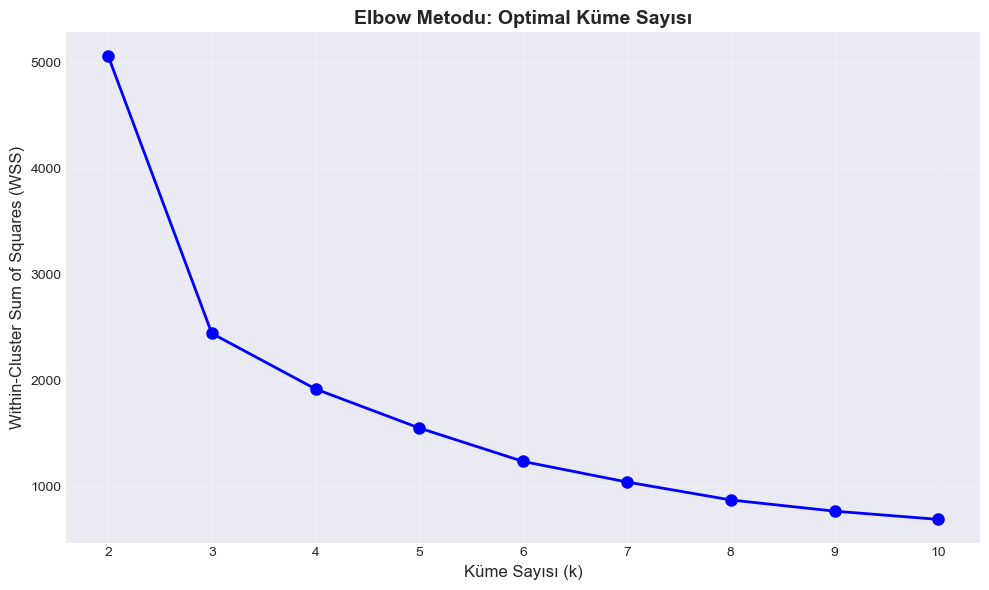

In [15]:
# Kümeleme için veri hazırla
cluster_data = merged_std[['StatePower', 'SocietyPower']].dropna()
cluster_indices = cluster_data.index

print(f"Kümeleme için hazırlık: {len(cluster_data)} gözlem")

# Elbow metodu - farklı k değerleri için WSS hesapla
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data)
    inertias.append(kmeans.inertia_)

# Elbow grafiği
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax.set_ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
ax.set_title('Elbow Metodu: Optimal Küme Sayısı', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Tüm gözlemlerin faktör skorlarına bakın
plt.scatter(cluster_data['StatePower'], cluster_data['SocietyPower'], alpha=0.3)

In [ ]:
# K=4 ile kümeleme yap
kmeans_3 = KMeans(n_clusters=4, random_state=42, n_init=20)
cluster_labels = kmeans_3.fit_predict(cluster_data)

# Ana veri setine ekle
merged_std.loc[cluster_indices, 'Cluster'] = cluster_labels

# Küme merkezlerini görüntüle
centers = pd.DataFrame(
    kmeans_3.cluster_centers_,
    columns=['StatePower', 'SocietyPower'],
    index=[f'Cluster {i}' for i in range(4)]
)

print("\n" + "="*60)
print("KÜME MERKEZLERİ (K=4)")
print("="*60)
print(centers.round(3))

# Her kümenin özelliklerini yorumla
print("\n" + "="*60)
print("KÜME YORUMLAMA")
print("="*60)
for i in range(4):
    sp = centers.loc[f'Cluster {i}', 'StatePower']
    sop = centers.loc[f'Cluster {i}', 'SocietyPower']
    count = (merged_std['Cluster'] == i).sum()
    
    # Leviathan tipini belirle
    if sp > 0.5 and sop > 0.5:
        lev_type = "Prangalanmış Leviathan (Shackled)"
    elif sp > 0.5 and sop < 0:
        lev_type = "Despotik Leviathan (Despotic)"
    elif sp < 0 and sop > 0:
        lev_type = "Mevcut Olmayan Leviathan (Absent)"
    elif sp < 0 and sop < 0:
        lev_type = "Kağıttan Leviathan (Paper)"
    else:
        lev_type = "Belirsiz"
    
    print(f"\nCluster {i}: {lev_type}")
    print(f"  StatePower:   {sp:6.3f}")
    print(f"  SocietyPower: {sop:6.3f}")
    print(f"  Gözlem sayısı: {count}")


KÜME MERKEZLERİ (K=4)
           StatePower  SocietyPower
Cluster 0       1.266         0.508
Cluster 1      -1.036        -0.300
Cluster 2      -0.483         0.697
Cluster 3       0.161        -1.677

KÜME YORUMLAMA

Cluster 0: Prangalanmış Leviathan (Shackled)
  StatePower:    1.266
  SocietyPower:  0.508
  Gözlem sayısı: 1104

Cluster 1: Kağıttan Leviathan (Paper)
  StatePower:   -1.036
  SocietyPower: -0.300
  Gözlem sayısı: 736

Cluster 2: Mevcut Olmayan Leviathan (Absent)
  StatePower:   -0.483
  SocietyPower:  0.697
  Gözlem sayısı: 1599

Cluster 3: Belirsiz
  StatePower:    0.161
  SocietyPower: -1.677
  Gözlem sayısı: 867


In [ ]:
# Cluster'ları Leviathan tiplerine göre yeniden etiketle
# Merkezlere göre manuel etiketleme
cluster_mapping = {}

for i in range(4):
    sp = centers.loc[f'Cluster {i}', 'StatePower']
    sop = centers.loc[f'Cluster {i}', 'SocietyPower']
    
    if sp > 0.5 and sop > 0.5:
        cluster_mapping[i] = "Shackled"
    elif sp > 0.5 and sop < -0.3:
        cluster_mapping[i] = "Despotic"
    elif sp < -0.3 and sop < -0.3:
        cluster_mapping[i] = "Paper"
    elif sp < 0 and sop > 0.5:
        cluster_mapping[i] = "Absent"
    else:
        # Daha esnek kriterler
        if sp > sop and sp > 0:
            cluster_mapping[i] = "Despotic"
        elif sop > sp and abs(sp) < 1 and abs(sop) < 1:
            cluster_mapping[i] = "Paper"
        elif sp > 0 and sop > 0:
            cluster_mapping[i] = "Shackled"
        else:
            cluster_mapping[i] = "Paper"

merged_std['LeviathanType'] = merged_std['Cluster'].map(cluster_mapping)

print("\n✓ Leviathan tipleri etiketlendi:")
print(merged_std['LeviathanType'].value_counts())
print(f"\n✓ Cluster -> Leviathan eşlemesi:")
for k, v in cluster_mapping.items():
    print(f"  Cluster {k} -> {v}")


✓ Leviathan tipleri etiketlendi:
LeviathanType
Absent      1599
Shackled    1104
Despotic     867
Paper        736
Name: count, dtype: int64

✓ Cluster -> Leviathan eşlemesi:
  Cluster 0 -> Shackled
  Cluster 1 -> Paper
  Cluster 2 -> Absent
  Cluster 3 -> Despotic


## 7. Görselleştirme: 1996 ve 2022 Karşılaştırması

Dar Koridor grafiklerini oluşturuyoruz. 1996'da ülkelerin konumu ile 2022'deki konumlarını karşılaştırıyoruz.


1996: 167 ülke
2022: 174 ülke


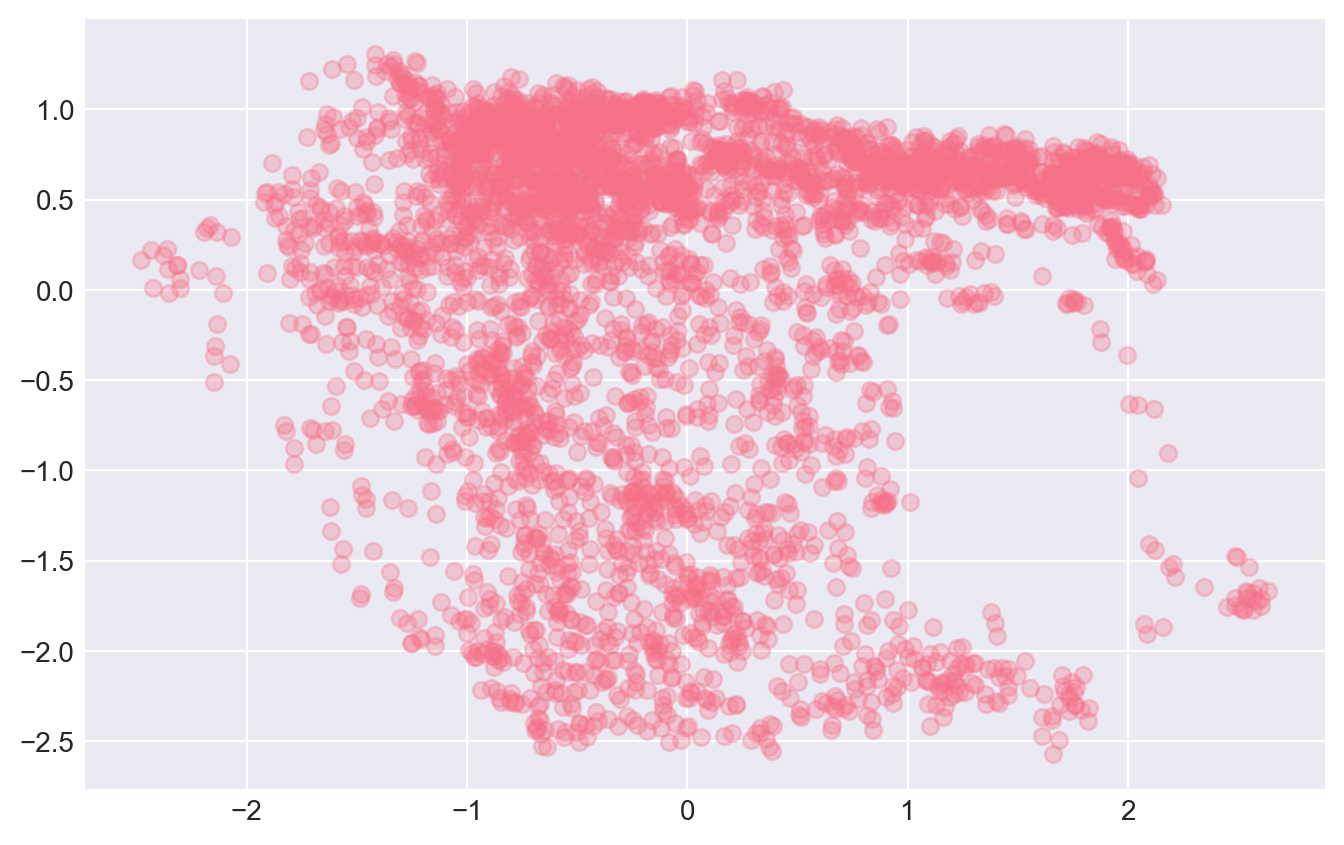

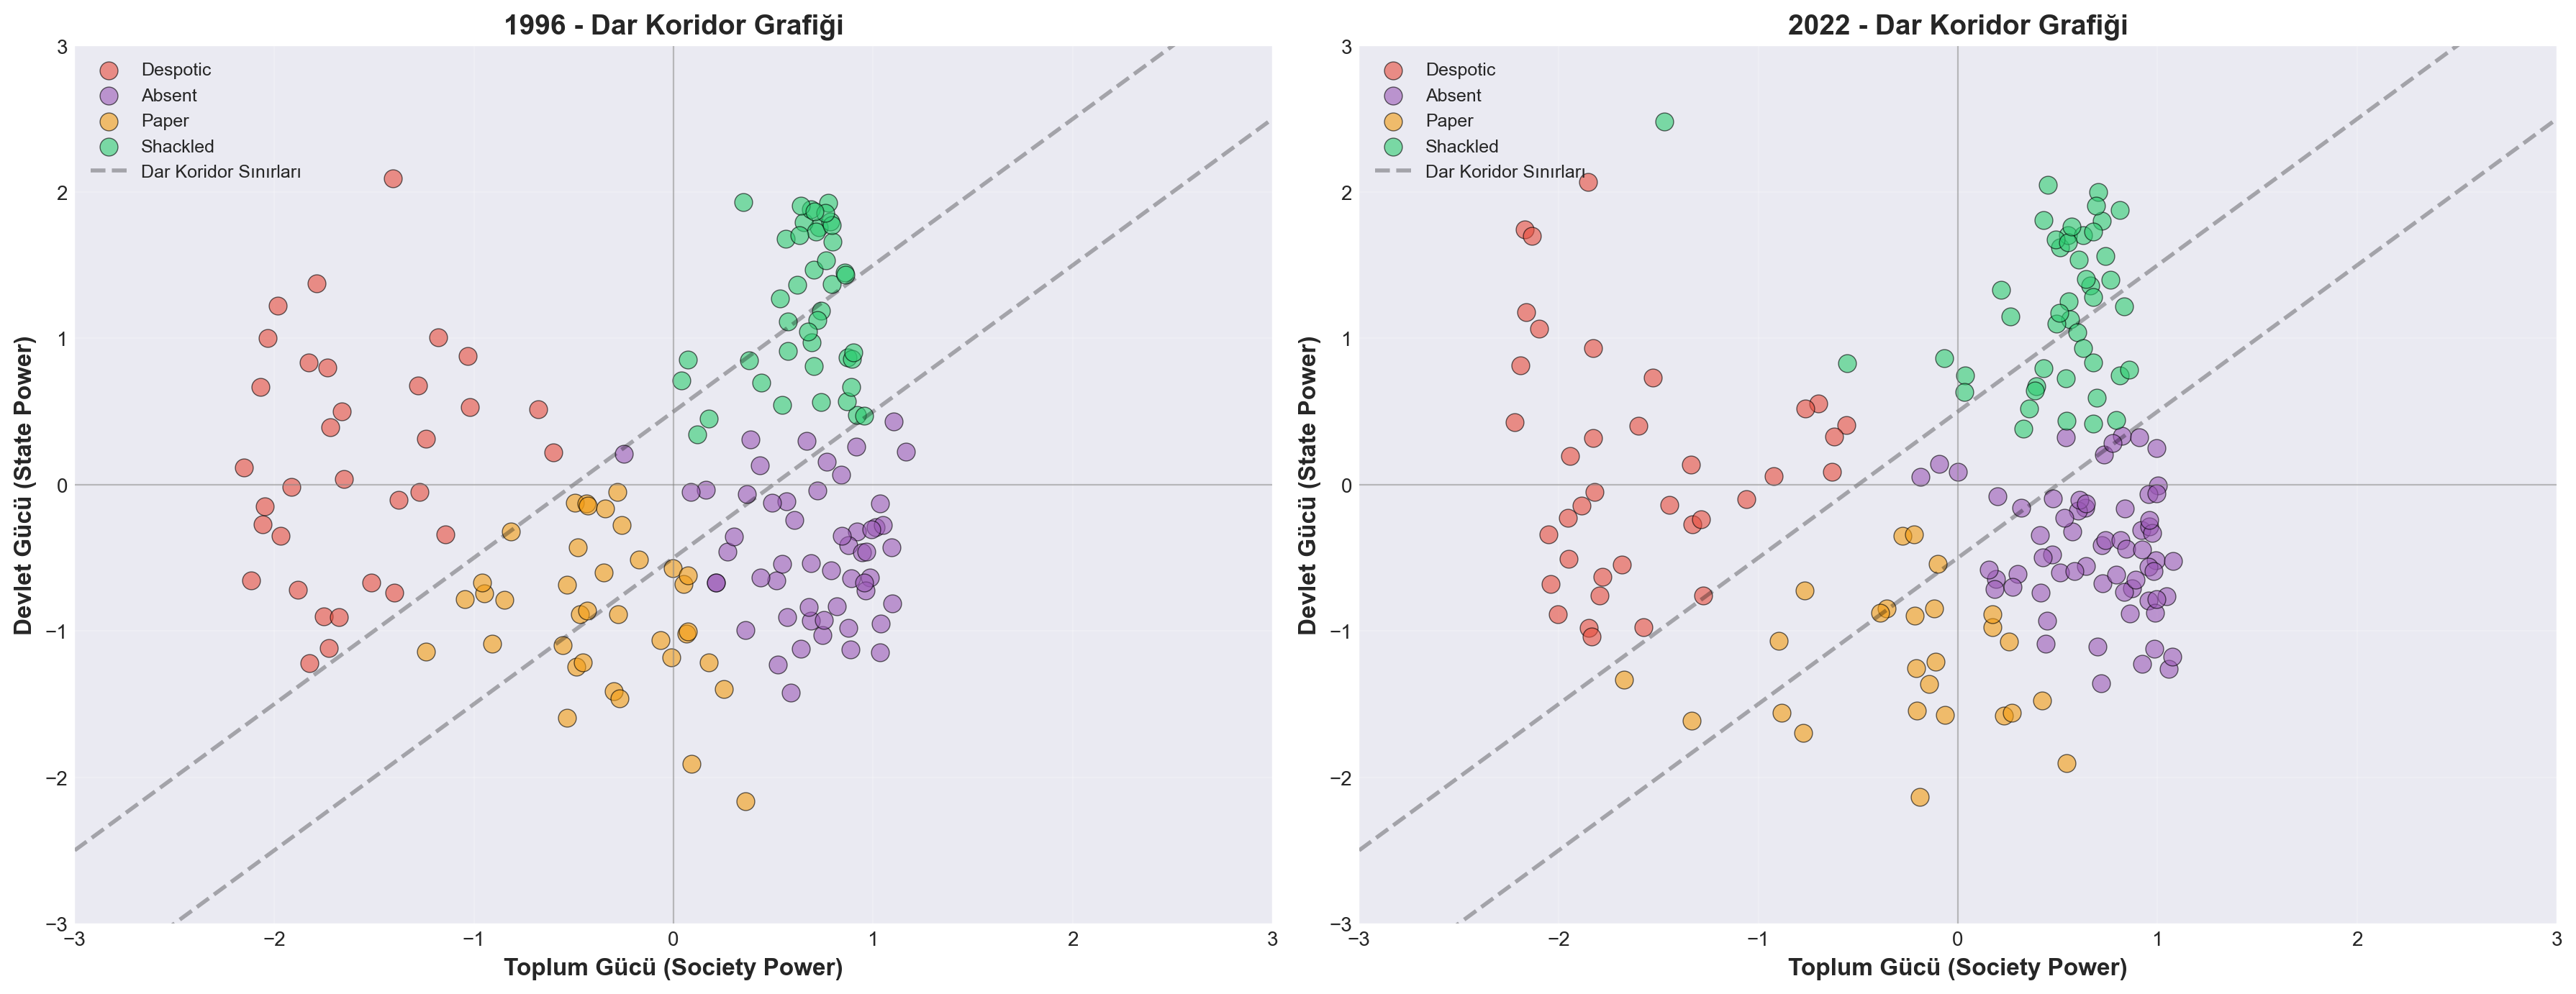


✓ 1996 ve 2022 Dar Koridor grafikleri oluşturuldu


In [ ]:
# 1996 ve 2022 verilerini hazırla
data_1996 = merged_std[merged_std['year'] == 1996].copy()
data_2022 = merged_std[merged_std['year'] == 2022].copy()

print(f"1996: {len(data_1996)} ülke")
print(f"2022: {len(data_2022)} ülke")

# Renk paleti
color_map = {
    'Shackled': '#2ecc71',  # Yeşil
    'Despotic': '#e74c3c',  # Kırmızı
    'Paper': '#f39c12',     # Turuncu
    'Absent': '#9b59b6'     # Mor
}

# 1996 grafiği
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, (year, data) in enumerate([(1996, data_1996), (2022, data_2022)]):
    ax = axes[idx]
    
    # Her Leviathan tipi için ayrı scatter
    for lev_type in data['LeviathanType'].unique():
        if pd.isna(lev_type):
            continue
        subset = data[data['LeviathanType'] == lev_type]
        ax.scatter(subset['SocietyPower'], subset['StatePower'],
                  c=color_map.get(lev_type, 'gray'),
                  label=lev_type, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Dar Koridor çizgileri (yaklaşık)
    x_corr = np.linspace(-3, 3, 100)
    y_upper = x_corr + 0.5  # Üst sınır
    y_lower = x_corr - 0.5  # Alt sınır
    ax.plot(x_corr, y_upper, 'k--', alpha=0.3, linewidth=2, label='Dar Koridor Sınırları')
    ax.plot(x_corr, y_lower, 'k--', alpha=0.3, linewidth=2)
    
    # Eksen ve grid
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, alpha=0.2)
    
    # Etiketler
    ax.set_xlabel('Toplum Gücü (Society Power)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Devlet Gücü (State Power)', fontsize=12, fontweight='bold')
    ax.set_title(f'{year} - Dar Koridor Grafiği', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

print("\n✓ 1996 ve 2022 Dar Koridor grafikleri oluşturuldu")


In [ ]:
# İnteraktif Plotly grafiği (2022)
fig = px.scatter(
    data_2022,
    x='SocietyPower',
    y='StatePower',
    color='LeviathanType',
    hover_name='countryname',
    hover_data={'StatePower': ':.2f', 'SocietyPower': ':.2f', 'LeviathanType': True},
    title='2022 - Dar Koridor: Devlet ve Toplum Gücü (İnteraktif)',
    color_discrete_map=color_map,
    labels={
        'StatePower': 'Devlet Gücü',
        'SocietyPower': 'Toplum Gücü',
        'LeviathanType': 'Leviathan Tipi'
    }
)

# Dar Koridor çizgileri ekle
x_line = np.linspace(-3, 3, 50)
fig.add_trace(go.Scatter(x=x_line, y=x_line + 0.5, mode='lines',
                         line=dict(color='black', dash='dash', width=2),
                         name='Dar Koridor (Üst)', showlegend=False))
fig.add_trace(go.Scatter(x=x_line, y=x_line - 0.5, mode='lines',
                         line=dict(color='black', dash='dash', width=2),
                         name='Dar Koridor (Alt)', showlegend=False))

# Eksen çizgileri
fig.add_hline(y=0, line_dash="solid", line_color="gray", opacity=0.3)
fig.add_vline(x=0, line_dash="solid", line_color="gray", opacity=0.3)

fig.update_layout(
    width=900,
    height=700,
    xaxis=dict(range=[-3, 3], title_font=dict(size=14)),
    yaxis=dict(range=[-3, 3], title_font=dict(size=14)),
    font=dict(size=12),
    hovermode='closest'
)

fig.show()

print("\n✓ İnteraktif Plotly grafiği oluşturuldu")



✓ İnteraktif Plotly grafiği oluşturuldu


## 8. Freedom House Karşılaştırması (2022)

Modelimizin bulduğu Leviathan tiplerini Freedom House'un rejim sınıflandırmasıyla karşılaştırıyoruz.


In [ ]:
# Freedom House verisini yükle
print("Freedom House verisi yükleniyor...")
fh = pd.read_csv('../Datasets/FIW13-25-Tablo 1.csv', sep=';', skiprows=1)

# 2025 verisini filtrele (en güncel)
fh_2025 = fh[fh['Edition'] == 2025].copy()

# Sadece country (c) olanları al, territory (t) hariç
fh_2025 = fh_2025[fh_2025['C/T'] == 'c'].copy()

# Ülke adlarını normalize et (basit eşleştirme)
fh_2025['Country/Territory'] = fh_2025['Country/Territory'].str.strip()

print(f"✓ Freedom House 2025: {len(fh_2025)} ülke")
print(f"  Status kategorileri: {fh_2025['Status'].unique()}")
print(f"  F=Free, PF=Partly Free, NF=Not Free")

Freedom House verisi yükleniyor...
✓ Freedom House 2025: 195 ülke
  Status kategorileri: ['NF' 'PF' 'F']
  F=Free, PF=Partly Free, NF=Not Free


In [ ]:
# 2022 verilerimizle birleştir
# Önce ülke adlarını FH formatına yaklaştır
data_2022_comp = data_2022.copy()

# Birleştir
comparison = pd.merge(
    data_2022_comp,
    fh_2025[['Country/Territory', 'Status']],
    left_on='countryname',
    right_on='Country/Territory',
    how='inner'
)

print(f"\n✓ Eşleşen ülke sayısı: {len(comparison)}")

# Çapraz tablo
crosstab = pd.crosstab(
    comparison['LeviathanType'],
    comparison['Status'],
    margins=True
)

print("\n" + "="*60)
print("LEVIATHAN TİPİ vs FREEDOM HOUSE STATUS (2022/2025)")
print("="*60)
print(crosstab)

# Yüzde tablosu
crosstab_pct = pd.crosstab(
    comparison['LeviathanType'],
    comparison['Status'],
    normalize='index'
) * 100

print("\n" + "="*60)
print("YÜZDE DAĞILIM (Satır bazında)")
print("="*60)
print(crosstab_pct.round(1))



✓ Eşleşen ülke sayısı: 158

LEVIATHAN TİPİ vs FREEDOM HOUSE STATUS (2022/2025)
Status          F  NF  PF  All
LeviathanType                 
Absent         22   4  37   63
Despotic        0  28   3   31
Paper           0  16   6   22
Shackled       38   0   4   42
All            60  48  50  158

YÜZDE DAĞILIM (Satır bazında)
Status            F    NF    PF
LeviathanType                  
Absent         34.9   6.3  58.7
Despotic        0.0  90.3   9.7
Paper           0.0  72.7  27.3
Shackled       90.5   0.0   9.5


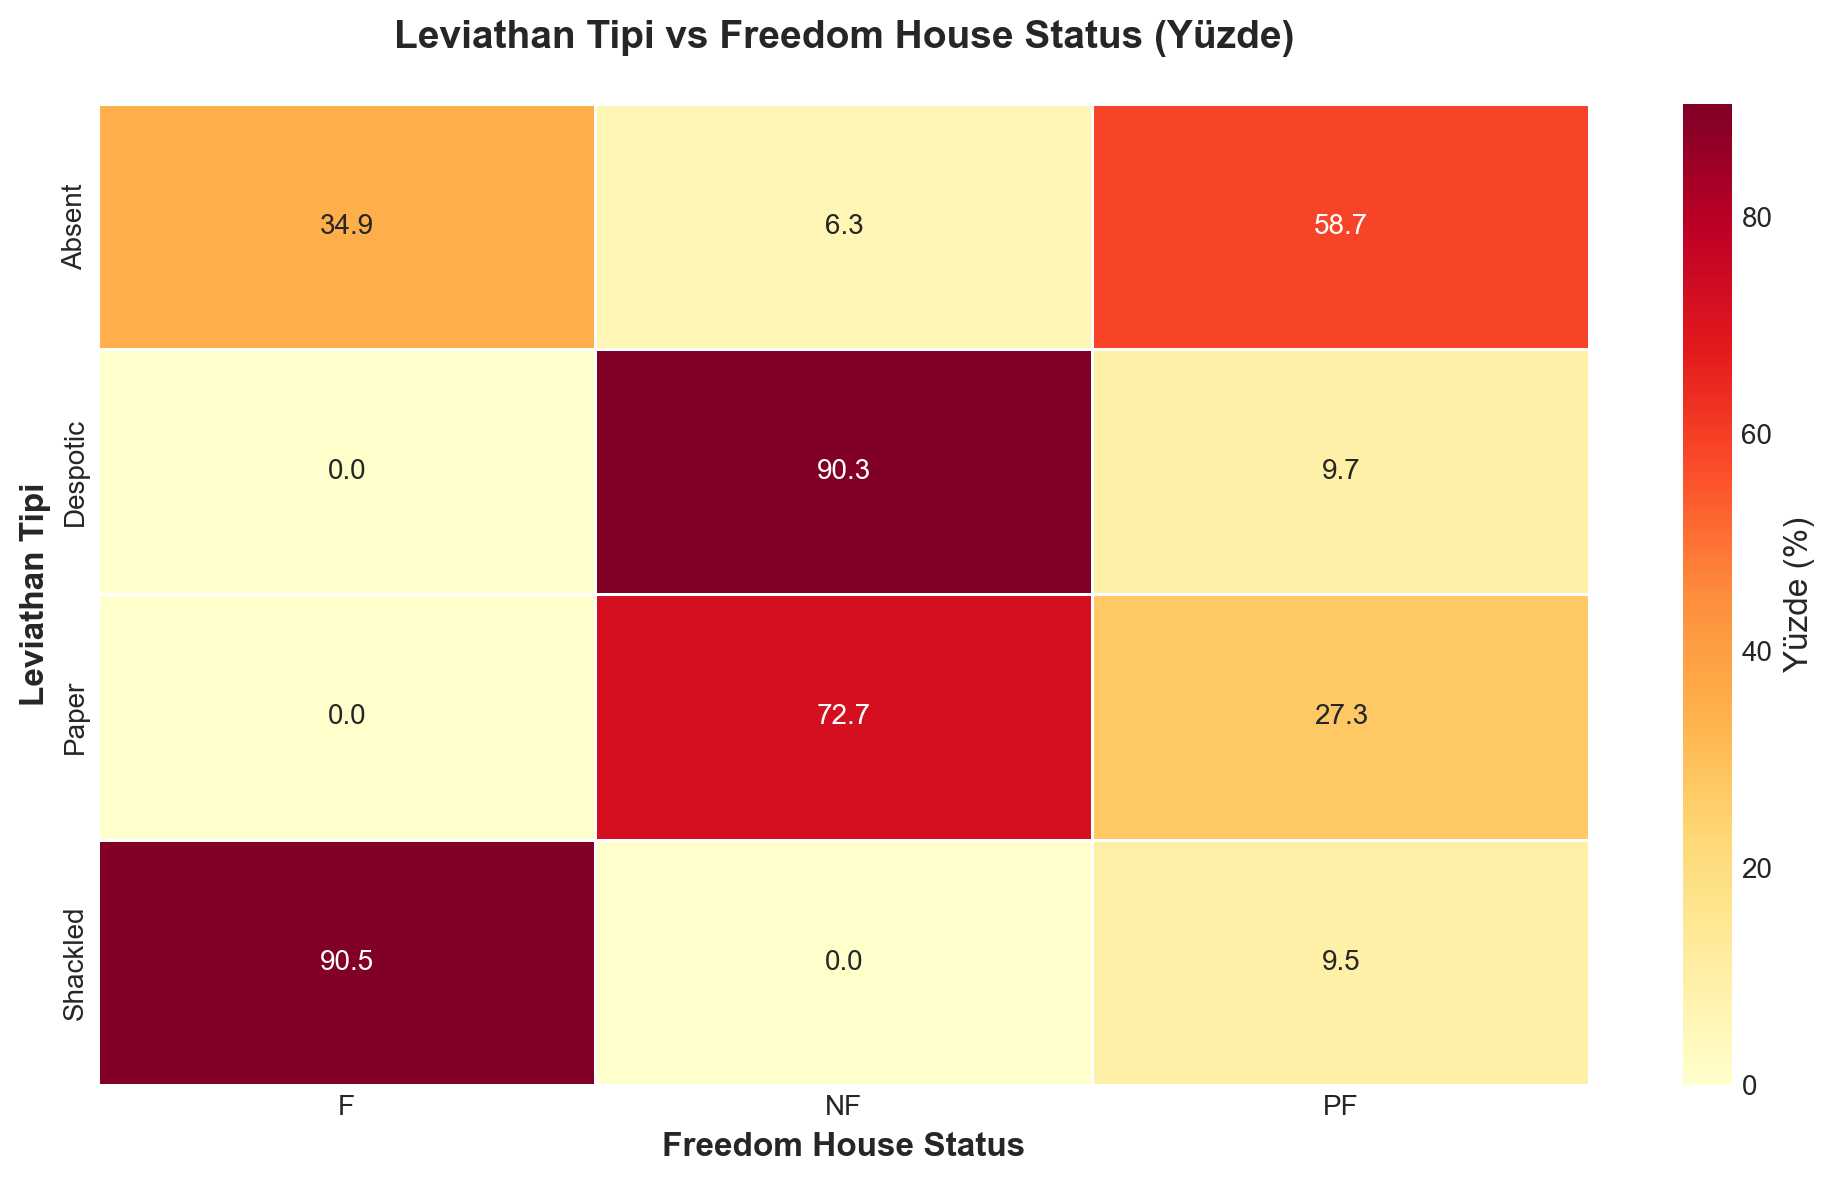


✓ Karşılaştırma ısı haritası oluşturuldu


In [ ]:
# Isı haritası
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Yüzde (%)'}, linewidths=0.5,
            ax=ax)
ax.set_title('Leviathan Tipi vs Freedom House Status (Yüzde)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Freedom House Status', fontsize=12, fontweight='bold')
ax.set_ylabel('Leviathan Tipi', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Karşılaştırma ısı haritası oluşturuldu")


## 9. Veri Eksportu

Hesaplanan faktör skorlarını ve kümeleri CSV ve JSON formatlarında kaydediyoruz.


In [ ]:
# Tüm yıllar için CSV eksportu
export_cols = ['countryname', 'year', 'StatePower', 'SocietyPower', 'Cluster', 'LeviathanType']
export_df = merged_std[export_cols].copy()

# Eksik değerleri temizle
export_df = export_df.dropna(subset=['StatePower', 'SocietyPower'])

# CSV olarak kaydet
output_csv = '../Datasets/processed/factor_scores_1996_2022.csv'
export_df.to_csv(output_csv, index=False)

print(f"✓ Tüm yıllar CSV'ye kaydedildi: {output_csv}")
print(f"  Toplam {len(export_df)} gözlem ({export_df['countryname'].nunique()} ülke)")
print(f"  Yıl aralığı: {export_df['year'].min()}-{export_df['year'].max()}")


✓ Tüm yıllar CSV'ye kaydedildi: ../Datasets/processed/factor_scores_1996_2022.csv
  Toplam 4306 gözlem (174 ülke)
  Yıl aralığı: 1996-2023


In [ ]:
# 2022 verisini JSON formatında kaydet (web paneli için)
data_2022_export = data_2022[['countryname', 'StatePower', 'SocietyPower', 
                               'LeviathanType', 'Cluster']].copy()
data_2022_export = data_2022_export.dropna()

# JSON yapısını oluştur
json_output = {
    'year': 2022,
    'countries': []
}

for _, row in data_2022_export.iterrows():
    json_output['countries'].append({
        'name': row['countryname'],
        'statePower': round(float(row['StatePower']), 3),
        'societyPower': round(float(row['SocietyPower']), 3),
        'leviathanType': row['LeviathanType'],
        'cluster': int(row['Cluster'])
    })

# JSON olarak kaydet
output_json = '../Datasets/processed/dar_koridor_latest_2022.json'
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(json_output, f, ensure_ascii=False, indent=2)

print(f"\n✓ 2022 verisi JSON'a kaydedildi: {output_json}")
print(f"  {len(json_output['countries'])} ülke")

# İlk 3 ülkeyi göster
print(f"\n✓ JSON yapısı (ilk 3 ülke):")
for country in json_output['countries'][:3]:
    print(f"  {country['name']}: SP={country['statePower']}, SoP={country['societyPower']}, Type={country['leviathanType']}")



✓ 2022 verisi JSON'a kaydedildi: ../Datasets/processed/dar_koridor_latest_2022.json
  174 ülke

✓ JSON yapısı (ilk 3 ülke):
  Afghanistan: SP=-0.98, SoP=-1.848, Type=Despotic
  Albania: SP=-0.158, SoP=0.639, Type=Absent
  Algeria: SP=-0.14, SoP=-1.447, Type=Despotic


## 10. Özet ve Bulgular

Analiz tamamlandı. Aşağıda temel bulguları özetliyoruz.


In [ ]:
print("="*70)
print("ANALİZ ÖZET RAPORU")
print("="*70)

print(f"\n📊 VERİ KAPSAMI:")
print(f"  • Yıl aralığı: {export_df['year'].min()}-{export_df['year'].max()}")
print(f"  • Toplam gözlem: {len(export_df)}")
print(f"  • Ülke sayısı: {export_df['countryname'].nunique()}")

print(f"\n🔍 FAKTÖR ANALİZİ:")
print(f"  • 2 faktör çıkarıldı (Devlet Gücü, Toplum Gücü)")
print(f"  • Toplam varyans açıklama: {variance_df.loc['Cumulative Var', 'Factor2']:.1%}")
print(f"  • Rotasyon: Varimax")

print(f"\n🎯 KÜMELEME (K=4):")
for lev_type in export_df['LeviathanType'].unique():
    if pd.notna(lev_type):
        count = (export_df['LeviathanType'] == lev_type).sum()
        pct = count / len(export_df) * 100
        print(f"  • {lev_type}: {count} gözlem ({pct:.1f}%)")

print(f"\n📈 1996 vs 2022 KARŞILAŞTIRMASI:")
print(f"  • 1996: {len(data_1996)} ülke")
print(f"  • 2022: {len(data_2022)} ülke")

print(f"\n✅ ÇIKTILAR:")
print(f"  • CSV: {output_csv}")
print(f"  • JSON: {output_json}")

print("\n" + "="*70)
print("Analiz başarıyla tamamlandı!")
print("="*70)


ANALİZ ÖZET RAPORU

📊 VERİ KAPSAMI:
  • Yıl aralığı: 1996-2023
  • Toplam gözlem: 4306
  • Ülke sayısı: 174

🔍 FAKTÖR ANALİZİ:
  • 2 faktör çıkarıldı (Devlet Gücü, Toplum Gücü)
  • Toplam varyans açıklama: 88.3%
  • Rotasyon: Varimax

🎯 KÜMELEME (K=4):
  • Despotic: 867 gözlem (20.1%)
  • Paper: 736 gözlem (17.1%)
  • Absent: 1599 gözlem (37.1%)
  • Shackled: 1104 gözlem (25.6%)

📈 1996 vs 2022 KARŞILAŞTIRMASI:
  • 1996: 167 ülke
  • 2022: 174 ülke

✅ ÇIKTILAR:
  • CSV: ../Datasets/processed/factor_scores_1996_2022.csv
  • JSON: ../Datasets/processed/dar_koridor_latest_2022.json

Analiz başarıyla tamamlandı!
